1. Determining the quality of the text recognition process, both at the character level and the word level

a. by using a single distance metric

b. by using multiple distance metrics

In [7]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import os
import time

In [8]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [12]:
img = open("data/images/test2.jpeg", "rb")
read_response = computervision_client.read_in_stream(
    image=img,
    mode="Printed",
    raw=True
)
operation_id = read_response.headers['Operation-Location'].split('/')[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

result = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            result.append(line.text)
print(result)

['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']


a. by using a single distance metric - Levenshtein

In [10]:
import Levenshtein

true_text = ("Succes în rezolvarea "
             "tEMELOR la "
             "LABORAtoarele de "
             "Inteligență Artificială!")

#true_text = ("Google Cloud "
#             "Platform")
recognized_text = " ".join(w for w in result)
#print(true_text, recognized_text)
char_error_rate = Levenshtein.distance(true_text, recognized_text) / len(true_text)

true_words = true_text.split()
recognized_words = recognized_text.split()
#print(recognized_words)

word_error_rate = Levenshtein.distance(true_words, recognized_words) / len(true_words)

print(f"CER: {char_error_rate:.2%}", f"WER: {word_error_rate:.2%}")

CER: 10.96% WER: 88.89%


b. by using multiple distance metrics - Levenshtein, Hamming, Jaro-Winkler

Hamming: 100.00% Jaro-Winkler85.65%


<Figure size 1000x600 with 0 Axes>

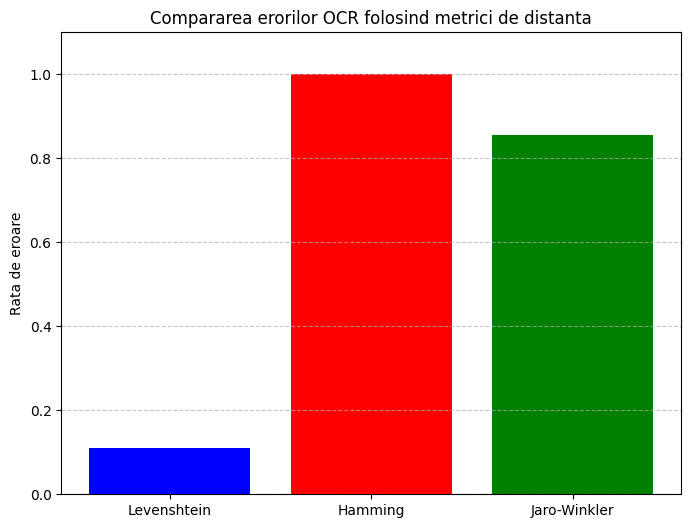

In [11]:
import jellyfish
from matplotlib import pyplot as plt
if len(true_text) == len(recognized_text):
    hamming_dist = jellyfish.hamming_distance(true_text, recognized_text)
else:
    hamming_dist = 1  # Nu este aplicabil

jaro_winkler_sim = jellyfish.jaro_winkler_similarity(true_text, recognized_text)

print(f"Hamming: {hamming_dist:.2%}", f"Jaro-Winkler: {jaro_winkler_sim:.2%}")

plt.figure(figsize=(10, 6))

distances = {"Levenshtein": char_error_rate,
        "Hamming": hamming_dist,
        "Jaro-Winkler": jaro_winkler_sim}

metrics = ["Levenshtein", "Hamming", "Jaro-Winkler"]

plt.figure(figsize=(8, 6))
bars = plt.bar(distances.keys(), distances.values(), color=['blue', 'red', 'green'])


plt.ylabel("Valoare metrica")
plt.ylim(0, max(distances.values()) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel("Rata de eroare")
plt.title("Compararea erorilor OCR folosind metrici de distanta")
plt.show()